## MISM2510 Stack Exchange Clustering

In [1]:
# imports
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.preprocessing import MinMaxScaler
from collections import Counter, defaultdict
from datetime import datetime
import seaborn as sns
import os

In [2]:
data = pd.read_csv('QueryResultswithActiveDate.csv')

In [3]:
# make days since account creation column
data['CreationDate'] = pd.to_datetime(data['CreationDate'])
today = pd.Timestamp(datetime.today().date())
data['DaysSinceCreation'] = (today - data['CreationDate']).dt.days
data['LastAccessDate'] = pd.to_datetime(data['LastAccessDate'])
data['DaysSinceActive'] = (today - data['LastAccessDate']).dt.days

In [4]:
# get total votes
data['TotalVotes'] = data['UpVotes'] + data['DownVotes']
data.drop(columns=['UpVotes', 'DownVotes'], inplace=True)

In [5]:
# drop CreationDate and fill all nulls
data.drop(columns=['CreationDate'], inplace=True)
data.drop(columns=['LastAccessDate'], inplace=True)

data.fillna(0, inplace=True)
data = data.apply(pd.to_numeric, errors='coerce').fillna(0)

In [6]:
data.head(1)

,Id,Reputation,NumPosts,TotalScore,TotalViews,TotalComments,DaysSinceCreation,DaysSinceActive,TotalVotes
0,7083860,1,0,0.0,0.0,0.0,3085,3085,0


In [7]:
# take out id column
user_ids = data['Id']
features = data.drop(columns=['Id'])

# scale data
scaler = MinMaxScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

# add ID back
scaled_data = pd.concat([user_ids, scaled_features], axis=1)

In [8]:
scaled_data.head(1)

,Id,Reputation,NumPosts,TotalScore,TotalViews,TotalComments,DaysSinceCreation,DaysSinceActive,TotalVotes
0,7083860,0.0,0.0,0.000724,0.0,0.0,0.506494,0.509759,0.0


In [9]:
# ID column for clustering
scaled_df_without_id = scaled_data.drop(columns=['Id'])
df_without_id = data.drop(columns=['Id'])

In [10]:
# make folder for plots
save_dir = 'plots2'
os.makedirs(save_dir, exist_ok=True)

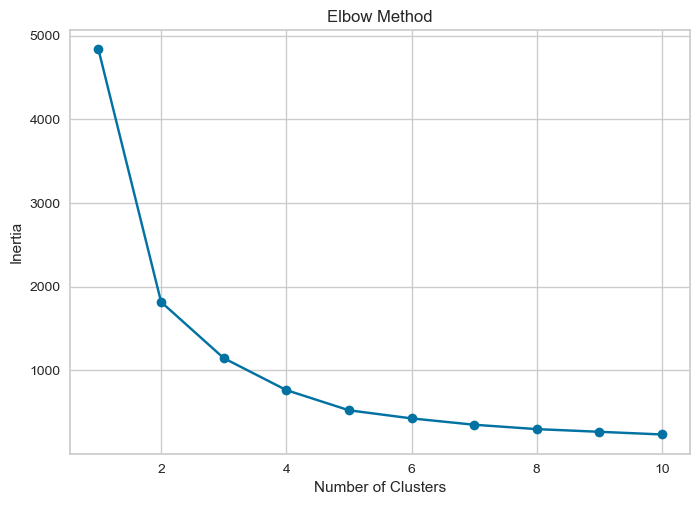

In [11]:
# find optimal k
inertia = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k,n_init=10, random_state=42)
    km.fit(scaled_df_without_id)
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.savefig("plots2/elbow_plot.png")
plt.show()

In [12]:
# perform clustering
k = 4

# Fit KMeans
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
scaled_data['Cluster'] = kmeans.fit_predict(scaled_df_without_id)

In [13]:
# group by cluster and calculate the means
scaled_df_without_id['Cluster'] = scaled_data['Cluster']
cluster_scaled_means = scaled_df_without_id.groupby('Cluster').mean()
cluster_scaled_means.round(2)

,Reputation,NumPosts,TotalScore,TotalViews,TotalComments,DaysSinceCreation,DaysSinceActive,TotalVotes
Cluster,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.61,0.57,0.0
1,0.0,0.0,0.0,0.0,0.0,0.08,0.06,0.0
2,0.0,0.0,0.0,0.0,0.0,0.62,0.10,0.0
3,0.0,0.0,0.0,0.0,0.0,0.30,0.25,0.0


In [14]:
# add cluster data
df_without_id['Cluster'] = scaled_data['Cluster']

# group by cluster and calculate the means
cluster_means = df_without_id.groupby('Cluster').mean()
cluster_means.round(2)

,Reputation,NumPosts,TotalScore,TotalViews,TotalComments,DaysSinceCreation,DaysSinceActive,TotalVotes
Cluster,,,,,,,,
0,39.99,1.20,3.32,3812.91,1.89,3719.83,3423.99,1.08
1,4.03,0.26,0.20,120.80,0.39,509.24,349.54,0.60
2,705.64,15.69,62.18,18874.73,23.60,3750.74,599.76,65.61
3,10.04,0.65,0.55,512.02,1.10,1821.93,1525.63,1.01


In [15]:
# names for clusters
cluster_names = {
    0: 'Ghost Writers',
    1: 'Newbies',
    2: 'Power Users',
    3: 'Passive Participants'
}

# map clusters to  names
df_without_id['Cluster'] = df_without_id['Cluster'].map(cluster_names)

sns.set(style="whitegrid")

# average for each feature by cluster
average_by_cluster = df_without_id.groupby('Cluster').mean()

In [16]:
average_by_cluster.head()

,Reputation,NumPosts,TotalScore,TotalViews,TotalComments,DaysSinceCreation,DaysSinceActive,TotalVotes
Cluster,,,,,,,,
Ghost Writers,39.991255,1.197797,3.320881,3812.912978,1.894191,3719.825632,3423.991147,1.084215
Newbies,4.027888,0.260242,0.196464,120.800422,0.392400,509.239302,349.543869,0.603191
Passive Participants,10.041446,0.645519,0.553815,512.022714,1.100973,1821.926898,1525.634228,1.008485
Power Users,705.641821,15.687115,62.179859,18874.730431,23.598285,3750.736148,599.757476,65.606640


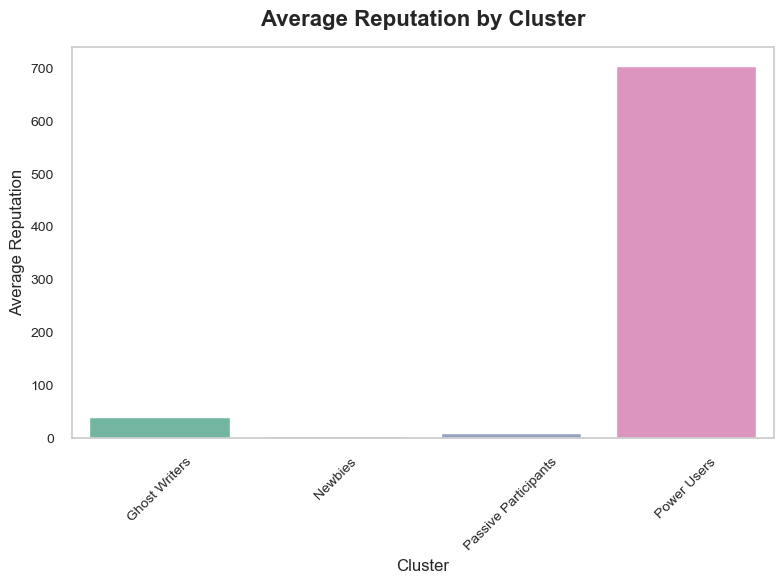

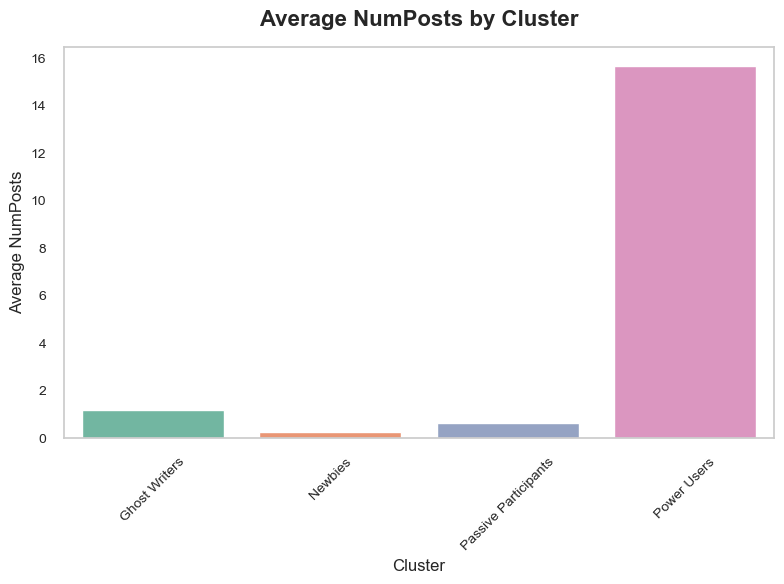

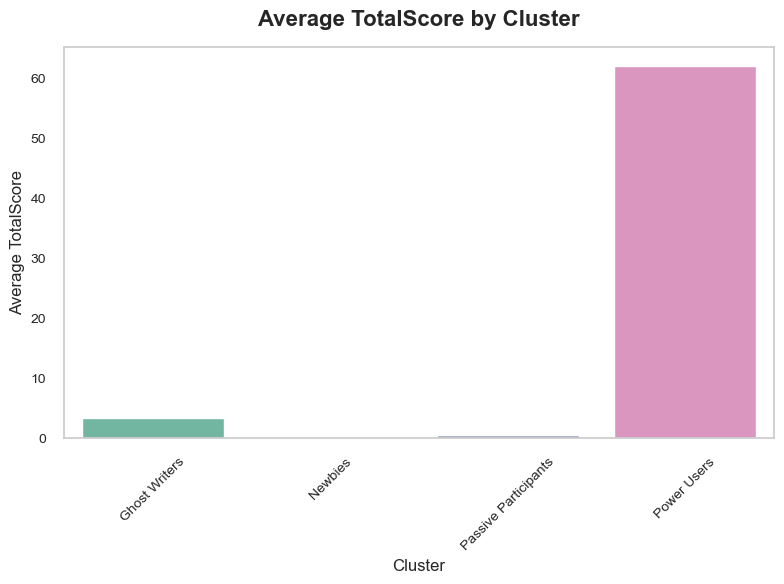

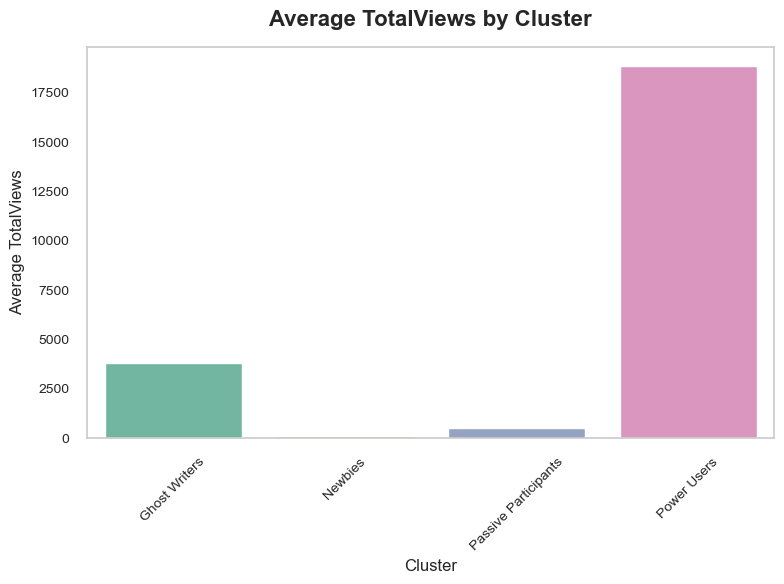

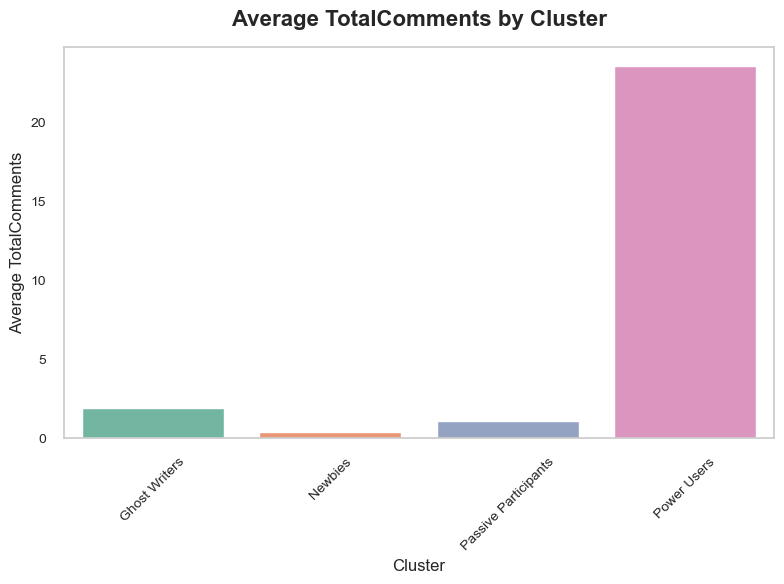

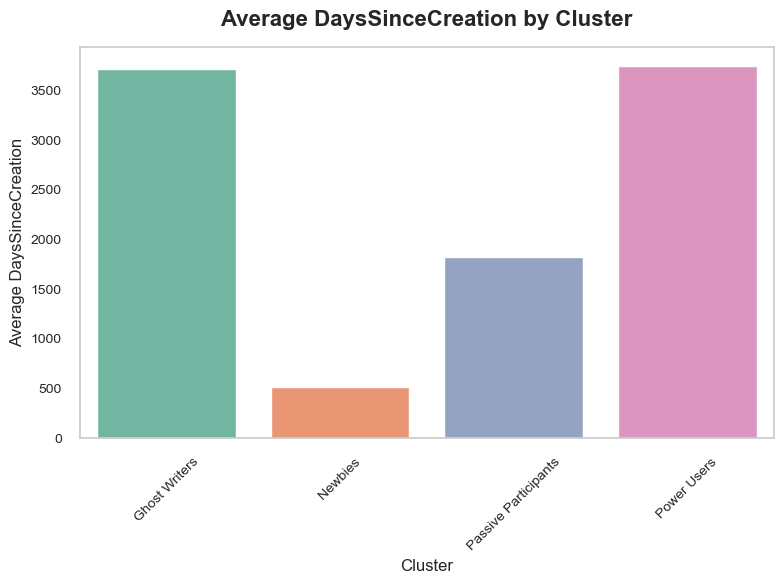

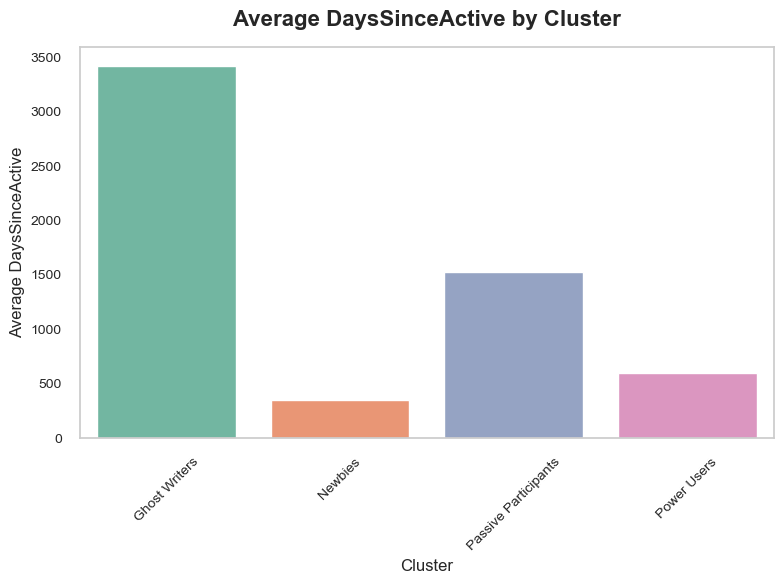

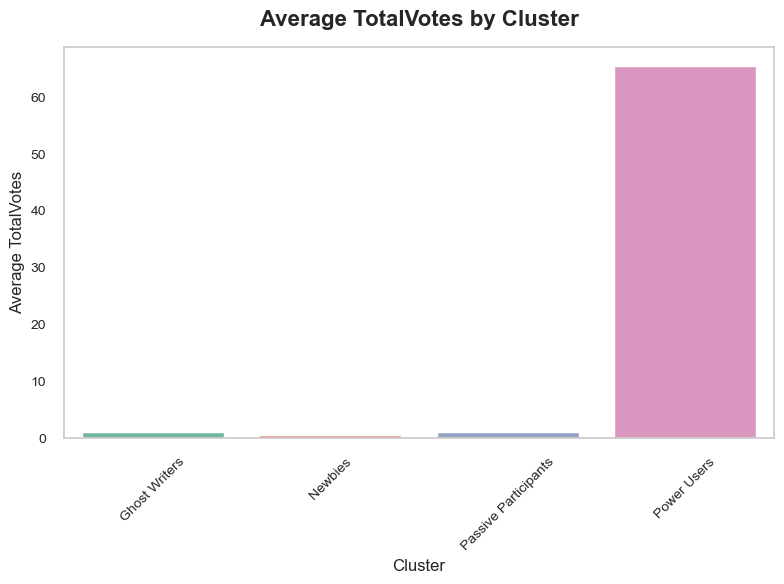

In [17]:
# bar plots for features
for column in average_by_cluster.columns:
    plt.figure(figsize=(8, 6))
    
    sns.barplot(x=average_by_cluster.index, y=average_by_cluster[column], palette="Set2")
    
    plt.title(f'Average {column} by Cluster', fontsize=16, weight='bold', pad=15)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel(f'Average {column}', fontsize=12)
    
    plt.xticks(fontsize=10, rotation=45)  
    plt.yticks(fontsize=10)
    
    plt.grid(False)
    plt.tight_layout()
    
    plot_filename = f'{save_dir}/average_{column}_by_cluster.png'
    plt.savefig(plot_filename)
    
    plt.show()